In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.concat([
    pd.read_json(DATA_DIR + "data.json.1", lines=True), 
    pd.read_json(DATA_DIR + "data.json", lines=True),
]).drop_duplicates(subset=["user", "track"])

In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [7]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(58704, 22208)

In [8]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [9]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [10]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [11]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# best_params = study.best_params

best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 50,
    'user_alpha': 0.0,
    'item_alpha': 0.0001
}

In [12]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.008280524052679539 +/- 0.0007119989326388344
1:	0.008787495084106922 +/- 0.0007453844184104295
2:	0.011632164940237999 +/- 0.0008978281844282522
3:	0.014082523994147778 +/- 0.0010362143337555364
4:	0.015687931329011917 +/- 0.0011244012077565218
5:	0.016870863735675812 +/- 0.001163254762343197
6:	0.01811012625694275 +/- 0.0012149085905907055
7:	0.019349386915564537 +/- 0.0012504622587503043
8:	0.020011266693472862 +/- 0.0012801209454694105
9:	0.02082805149257183 +/- 0.0013084711670867607
10:	0.021419519558548927 +/- 0.001320140343241579
11:	0.021940570324659348 +/- 0.001334194060791029
12:	0.022433463484048843 +/- 0.0013488110742564125
13:	0.0229685977101326 +/- 0.0013675343165259963
14:	0.023433320224285126 +/- 0.0013824102329596634
15:	0.023855796083807945 +/- 0.0013955249506873973
16:	0.024405013769865036 +/- 0.0014037394878377112
17:	0.024869738146662712 +/- 0.0014158300311728383
18:	0.025179555639624596 +/- 0.0014289515074117924
19:	0.025531617924571037 +/- 0.00143807333136963

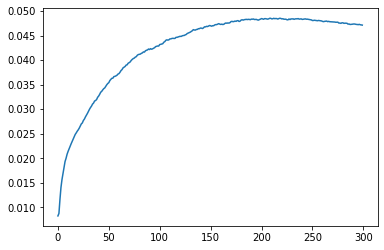

In [13]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [14]:
biases, embeddings = model.get_item_representations()

In [15]:
model.item_biases *= 0.0

In [16]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [17]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [18]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [19]:
dataset_tracks

,artist,title,track,dataset_index
24581,Jack's Mannequin,Bruised (Snakes Remix),24581,0.0
7,Kanye West,Stronger,7,1.0
8,Jack Johnson,Constellations,8,2.0
16393,Kanye West,Family Business,16393,3.0
10,Foo Fighters,Learn To Fly,10,4.0
...,...,...,...,...
8172,Nine Inch Nails,Wish,8172,4099.0
8174,Rihanna,Fire Bomb,8174,4100.0
32754,James Horner,Pure spirits of the forest (Album Version),32754,4101.0
8179,Phil Collins,You'll Be In My Heart,8179,4102.0


In [37]:
k = 20
max_tracks_from_same_artist = k

# TODO 1: Implement max tracks from same artist
with open(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        j = track["dataset_index"]
        
        recommendations = []
        if pd.notna(j):
            embedding = embeddings[int(j)]
            neighbours = np.argsort(-np.dot(embeddings, embedding))
            
            for neighbour in neighbours:
                recommended_track = dataset_tracks[dataset_tracks["dataset_index"] == neighbour].iloc[0]
                
                recommendation = int(recommended_track["track"])
                if recommendation == track["track"]:
                    continue
                
                recommendations.append(recommendation)

                if len(recommendations) == k:
                    break
         
        track_with_recommendations = dict(track)
        track_with_recommendations["recommendations"] = recommendations
        
        rf.write(json.dumps(track_with_recommendations) + "\n")

50000it [00:57, 863.95it/s] 


## How many unique artist per recommendation list?

In [38]:
dataset_track_artists = dict(zip(
    dataset_tracks["track"].values.tolist(),
    dataset_tracks["artist"].values.tolist(),
))

In [39]:
recs = pd.read_json(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", lines=True)
recs = recs[recs["dataset_index"].notnull()]

sample = recs.sample(frac=0.1).iloc[0]

print(sample["title"], "by" , sample["artist"], "\n===")
print("\n".join([dataset_track_artists[track] for track in sample["recommendations"]]))

Given Up (Album Version) by Linkin Park 
===
Linkin Park
Daughtry
Nickelback
Disturbed
Creedence Clearwater Revival
Zac Brown Band
Creed
Beyoncé
matchbox twenty
Slipknot
Foo Fighters
20 Minute Loop
Lifehouse
Nirvana
Muse
Shakira
Maroon 5
Phoenix
Arcade Fire
Puddle Of Mudd


In [40]:
def count_artists(tracks):
    return len(
        set([dataset_track_artists[track] for track in tracks])
    )


artist_counts = recs["recommendations"].map(count_artists)
artist_counts.value_counts()

20    4104
Name: recommendations, dtype: int64